<a href="https://colab.research.google.com/github/Jorgellamocca/Cambio-Clim-tico/blob/main/Era5_mensual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q xarray zarr fsspec==2025.3.0 numcodecs requests==2.32.4 aiohttp > /dev/null 2>&1
!apt-get install -qq -y libproj-dev proj-data proj-bin libgeos-dev > /dev/null 2>&1
!pip install -q cartopy shapely pyproj > /dev/null 2>&1


In [2]:
import xarray as xr
xr.backends.list_engines()


{'h5netcdf': <H5netcdfBackendEntrypoint>
   Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using h5netcdf in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.H5netcdfBackendEntrypoint.html,
 'scipy': <ScipyBackendEntrypoint>
   Open netCDF files (.nc, .cdf and .nc.gz) using scipy in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.ScipyBackendEntrypoint.html,
 'store': <StoreBackendEntrypoint>
   Open AbstractDataStore instances in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.StoreBackendEntrypoint.html,
 'zarr': <ZarrBackendEntrypoint>
   Open zarr files (.zarr) using zarr in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.ZarrBackendEntrypoint.html}

In [3]:
#Usar token registrado
TOKEN = "edh_pat_fcb2e9f52c35ff7fd7cc2f2d14317393c9e299c8c1c1f81a94216161433a0943f554036a62b849c1af67f0c0400c31e3"

# Crear el archivo
with open("/root/.netrc", "w") as f:
    f.write("machine data.earthdatahub.destine.eu\n")
    f.write(f"  password {TOKEN}\n")

# Permisos
!chmod 600 /root/.netrc

In [4]:
import xarray as xr
import pandas as pd

# -----------------------------
# Abrir dataset ERA5
# -----------------------------
url = "https://data.earthdatahub.destine.eu/era5/reanalysis-era5-single-levels-monthly-means-v0.zarr"

ds = xr.open_dataset(
    url,
    engine="zarr",
    chunks="auto",
    storage_options={"client_kwargs": {"trust_env": True}}
)

# -----------------------------
# Lista de variables
# -----------------------------
variables = []
for var in ds.data_vars:
    units = ds[var].attrs.get("units", "sin unidades")
    long_name = ds[var].attrs.get("long_name", "sin descripción")
    variables.append([var, units, long_name])

df = pd.DataFrame(variables, columns=["Variable", "Unidades", "Descripción"])

print("Variables disponibles en ERA5:\n")
print(df.to_string(index=False))

# -----------------------------
# Rango temporal del dataset
# -----------------------------
fechas = pd.to_datetime(ds.valid_time.values)

inicio = fechas.min().strftime("%Y-%m")
fin    = fechas.max().strftime("%Y-%m")

print("\nRango temporal del dataset ERA5:")
print(f"Inicio: {inicio}")
print(f"Fin:    {fin}")
print(f"Total de meses: {len(fechas)}")


Variables disponibles en ERA5:

Variable Unidades                  Descripción
     d2m        K 2 metre dewpoint temperature
     msl       Pa      Mean sea level pressure
      sp       Pa             Surface pressure
     sst        K      Sea surface temperature
     t2m        K          2 metre temperature
      tp        m          Total precipitation
     u10  m s**-1    10 metre U wind component
     v10  m s**-1    10 metre V wind component

Rango temporal del dataset ERA5:
Inicio: 1940-01
Fin:    2025-11
Total de meses: 1031


In [5]:
!apt-get -qq install libgeos-dev
!pip install -q cartopy

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [6]:
#Longitudes 0–360 → -180–180
ds = ds.assign_coords(
    longitude=((ds.longitude + 180) % 360) - 180
).sortby("longitude")

#Variable para todos los tiempos
variable_all = ds.t2m - 273.15
variable_all.attrs["units"] = "°C"


In [8]:
#Selccionamos un Dominio de ejemplo (lat, lon)
dominio = dict(
    latitude=slice(-3.2, -7.5),     # Piura
    longitude=slice(-82.5, -79.0)
)

In [9]:
#Elegir un Año y mes particular
YEAR, MONTH = 2017, 2

t2m_map = (
    variable_all
    .sel(valid_time=f"{YEAR}-{MONTH:02d}", **dominio)
    .isel(valid_time=0)
)

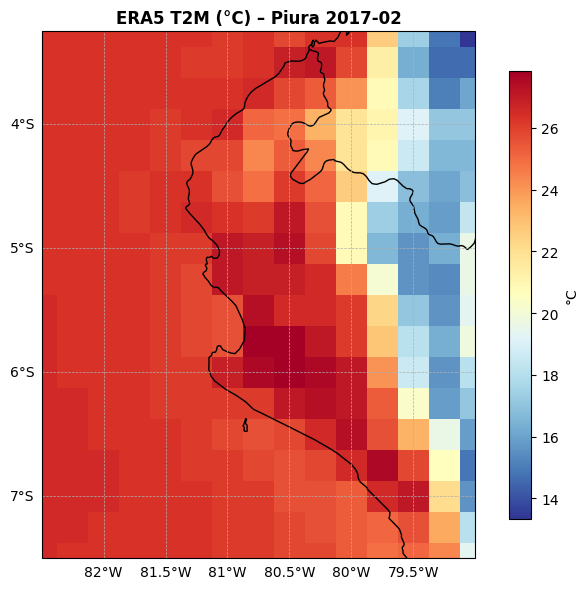

In [10]:
# Límites del campo
lon_min = float(t2m_map.longitude.min())
lon_max = float(t2m_map.longitude.max())
lat_min = float(t2m_map.latitude.min())
lat_max = float(t2m_map.latitude.max())

fig, ax = plt.subplots(
    figsize=(7,6),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

im = ax.pcolormesh(
    t2m_map.longitude,
    t2m_map.latitude,
    t2m_map,
    cmap="RdYlBu_r",
    shading="auto"
)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

#límites
ax.set_extent([lon_min, lon_max, lat_min, lat_max],
              crs=ccrs.PlateCarree())

# Lat/Lon
gl = ax.gridlines(draw_labels=True, linewidth=0.5, linestyle="--")
gl.top_labels = False
gl.right_labels = False

ax.set_title(
    f"ERA5 T2M (°C) – Piura {YEAR}-{MONTH:02d}",
    fontweight="bold"
)

plt.colorbar(im, ax=ax, label="°C", shrink=0.85)
plt.tight_layout()
plt.show()



In [11]:
t2m_piura = (variable_all.sel(**dominio).mean(dim=("latitude", "longitude")))

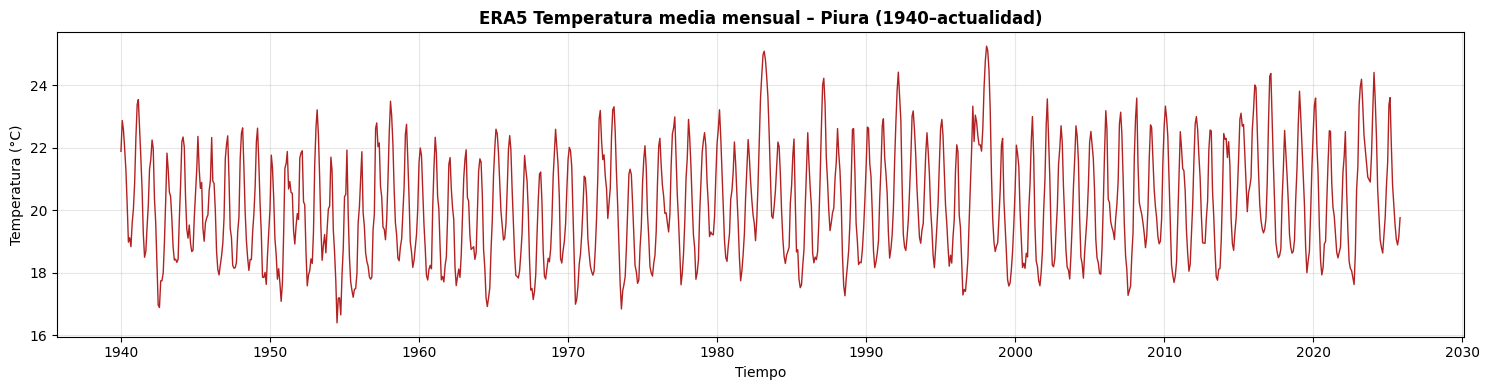

In [12]:
plt.figure(figsize=(15,4))

plt.plot(
    t2m_piura.valid_time,
    t2m_piura,
    linewidth=1,
    color="firebrick"
)

plt.title(
    "ERA5 Temperatura media mensual – Piura (1940–actualidad)",
    fontweight="bold"
)
plt.ylabel("Temperatura (°C)")
plt.xlabel("Tiempo")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
